In [1]:
import numpy as np
import pandas as pd
import random
import torch
import dgl
import os
import sys

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 현재 파일의 상위 디렉토리를 sys.path에 추가
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

c:\Programming\Anaconda\envs\chem\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 폰트 설정
import matplotlib as mpl
import matplotlib.font_manager as fm

font_path = r"C:\Windows\Fonts\malgun.ttf"  
font_prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
# 재현성 난수 고정
def SET_SEED():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    dgl.random.seed(SEED)

    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 100
SET_SEED()

In [4]:
dataset = 'VP' # VP
save_dir = r'..\results_figure\pca'

In [8]:
# # 상황분류
# df_class = pd.read_excel(r'..\datasets\vp_class3.xlsx')

# df_class.dropna(inplace = True)
# df_class['logvp'] = np.around(np.log(df_class['vapor pressure']), 2)
# df_class.reset_index(drop = True, inplace = True)
# df_class.head()

In [5]:
path = f'../datasets/{dataset}.csv'
df = pd.read_csv(path)
smiles_list = df['smiles'].tolist()

# target 정의
target = df.iloc[:,-1]

print(smiles_list[:5])
print(target[:5])

['COC(F)(F)C(F)(F)C(F)(F)F', 'COC(F)(F)C(F)(F)F', 'Brc1cc(Br)c(cc1)Oc1ccc(Br)c(Br)c1Br', 'Clc1c(Oc2ccccc2)c(Cl)ccc1Cl', 'Clc1cc(Oc2ccccc2)c(Cl)c(Cl)c1']
0    2.75
1    3.21
2   -8.14
3   -3.55
4   -3.66
Name: logvp, dtype: float64


In [6]:
from utils.utils import MolecularFeatureExtractor
# 분자 특성 추출 및 데이터프레임 정의
extractor = MolecularFeatureExtractor()
df_all_features = extractor.extract_molecular_features(smiles_list)

df_all_features['target'] = target
df_all_features

num_all_features = df_all_features.shape[1] - 1 
print("초기 변수 개수:", num_all_features)

# na handling
# NA 확인
df_all_features[df_all_features.isna().any(axis = 1)] # 행방향

# 결측치가 포함된 feature 개수
print('결측치가 포함된 열 개수:', df_all_features.isna().any(axis = 0).sum(), '\n')
print(df_all_features.isna().any(axis = 0))

print('결측치가 포함된 행 개수:', df_all_features.isna().any(axis = 1).sum(), '\n')
print(df_all_features.isna().any(axis = 1))

df_removed_features = df_all_features.dropna()

# 결측치가 포함된 feature 제거
# df_removed_features = df_all_features.dropna(axis = 1)
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features)

# 결측치가 제거된 data frame
df_removed_features

# 결측치가 포함된 feature 개수
print('결측치가 포함된 열 개수:', df_removed_features.isna().any(axis = 0).sum(), '\n')
print(df_removed_features.isna().any(axis = 0))

print('결측치가 포함된 행 개수:', df_removed_features.isna().any(axis = 1).sum(), '\n')
print(df_removed_features.isna().any(axis = 1))



# nunique == 1 인 경우는 제
unique_columns = list(df_removed_features.loc[:, df_removed_features.nunique() == 1].columns)
print('nunique == 1인 feature : \n', unique_columns, '\n')

# nunique == 1인 feature 제거
#df_removed_features.drop(columns = unique_columns, inplace = True)
df_removed_features = df_removed_features.drop(columns = unique_columns).copy()

num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)


# 너무 낮은 vairnace를 가지는 경
low_variances = sorted(df_removed_features.var())
low_variances[:10]

columns_low_variances = []

for i in low_variances:
    if i < 0.001:
        column = df_removed_features.loc[:, df_removed_features.var() == i].columns
        columns_low_variances.append(column)
columns_low_variances = [item for index in columns_low_variances for item in index]

# 2. 중복 제거 및 유니크 값 추출
columns_low_variances = list(set(columns_low_variances))
print(columns_low_variances)

# 낮은 분산의 변수 제거
df_removed_features = df_removed_features.drop(columns = columns_low_variances).reset_index(drop=True).copy()
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)

df_removed_features

초기 변수 개수: 208
결측치가 포함된 열 개수: 12 

MaxEStateIndex       False
MinEStateIndex       False
MaxAbsEStateIndex    False
MinAbsEStateIndex    False
qed                  False
                     ...  
fr_thiocyan          False
fr_thiophene         False
fr_unbrch_alkane     False
fr_urea              False
target               False
Length: 209, dtype: bool
결측치가 포함된 행 개수: 11 

0       False
1       False
2       False
3       False
4       False
        ...  
3568    False
3569    False
3570    False
3571    False
3572    False
Length: 3573, dtype: bool
제거 후 남은 feature 개수: 208
결측치가 포함된 열 개수: 0 

MaxEStateIndex       False
MinEStateIndex       False
MaxAbsEStateIndex    False
MinAbsEStateIndex    False
qed                  False
                     ...  
fr_thiocyan          False
fr_thiophene         False
fr_unbrch_alkane     False
fr_urea              False
target               False
Length: 209, dtype: bool
결측치가 포함된 행 개수: 0 

0       False
1       False
2       False
3       False
4   

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,11.734375,-6.326875,11.734375,0.055208,0.621657,200.053,197.029,200.007212,74,0.462384,...,0,0,0,0,0,0,0,0,0,2.750000
1,11.312500,-5.609375,11.312500,0.285208,0.517465,150.046,147.022,150.010406,56,0.482450,...,0,0,0,0,0,0,0,0,0,3.210000
2,5.865324,0.743609,5.865324,0.743609,0.348269,564.691,559.651,559.625725,94,0.142392,...,0,0,0,0,0,0,0,0,0,-8.140000
3,6.007009,0.317611,6.007009,0.317611,0.662096,273.546,266.490,271.956248,82,0.165603,...,0,0,0,0,0,0,0,0,0,-3.550000
4,5.999509,0.356407,5.999509,0.356407,0.662096,273.546,266.490,271.956248,82,0.148525,...,0,0,0,0,0,0,0,0,0,-3.660000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3557,12.369448,-0.052914,12.369448,0.045833,0.650472,236.270,224.174,236.083730,88,0.194023,...,0,0,0,0,0,0,0,0,0,-5.991400
3558,12.494448,0.134167,12.494448,0.134167,0.445095,230.266,220.186,230.073165,84,0.193794,...,0,0,0,0,0,0,0,0,0,-6.657577
3559,11.425278,-1.121250,11.425278,0.872593,0.706401,260.336,244.208,260.120115,98,0.140063,...,0,0,0,0,0,0,0,0,0,-7.522879
3560,2.274907,1.278241,2.274907,1.278241,0.384372,254.332,240.220,254.109550,94,-0.002682,...,0,0,0,0,0,0,0,0,0,-7.045757


# PCA

In [7]:
# target split
target = df_removed_features.iloc[:,-1]

# 1/3
med1 = np.percentile(target, 33)
med2 = np.percentile(target, 66)

low = np.where(target < med1)[0]
mid = np.where((target >= med1) & (target < med2))[0]
high = np.where(target >= med2)[0]

In [8]:
X = np.array(df_removed_features.drop(columns = ['target']))
X.shape

(3562, 191)

In [9]:
PCA_model2D = PCA(n_components = 2)
PCA_model3D = PCA(n_components = 3)

scaler = StandardScaler()

X_scaling = scaler.fit_transform(X)

X_pca2D = PCA_model2D.fit_transform(X_scaling)
X_pca3D = PCA_model3D.fit_transform(X_scaling)

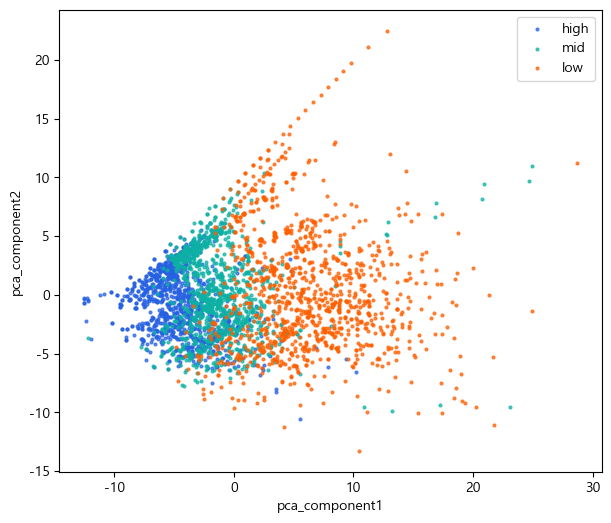

In [ ]:
# 3등분 2D
# pca
fig = plt.figure(figsize=(7, 6))
ax2 = fig.add_subplot(111)
2661E1
ax2.scatter(X_pca2D[high, 0], X_pca2D[high, 1], label='high', c='#2661E1', alpha=0.7, s=4)
ax2.scatter(X_pca2D[mid, 0], X_pca2D[mid, 1], label='mid', c='#0DB1A4', alpha=0.7, s=4)
ax2.scatter(X_pca2D[low, 0], X_pca2D[low, 1], label='low', c='#fe5f00', alpha=0.7, s=4)

ax2.set_xlabel('pca_component1')
ax2.set_ylabel('pca_component2')
ax2.legend()

# # 저장
# file_name = f'pca_{dataset}.png'
# file_path = os.path.join(save_dir, file_name)
# print(file_path)
# plt.savefig(file_path, dpi = 300, bbox_inches = 'tight')

plt.show()

..\results_figure\pca\7.pdf


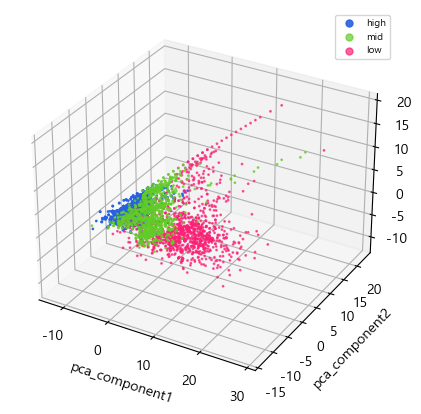

In [73]:
# 3등분 3D
# pca
fig = plt.figure(figsize=(6.69, 5))
ax2 = fig.add_subplot(111, projection = '3d')

ax2.scatter(X_pca3D[high, 0], X_pca3D[high, 1], X_pca3D[high, 2], label='high', c='#2661e1', alpha=0.9, s = 1)
ax2.scatter(X_pca3D[mid, 0], X_pca3D[mid, 1], X_pca3D[mid, 2], label='mid', c='#62CC28', alpha=0.7, s = 1)
ax2.scatter(X_pca3D[low, 0], X_pca3D[low, 1], X_pca3D[low, 2], label='low', c='#FC2175', alpha=0.7, s = 1)

ax2.set_xlabel('pca_component1')
ax2.set_ylabel('pca_component2')
ax2.set_zlabel('pca_component3')
ax2.legend(markerscale=5, fontsize=7)

# 저장
file_name = '7.pdf'
file_path = os.path.join(save_dir, file_name)
print(file_path)
plt.savefig(file_path, dpi = 300, bbox_inches = 'tight')

plt.show()

# 4등분

In [18]:
# target split
target = df_removed_features.iloc[:,-1]

# 1/4
qq1 = np.percentile(target, 25)
qq2 = np.percentile(target, 50)
qq3 = np.percentile(target, 75)

q1  = np.where(target < qq1)[0]
q2  = np.where((target >= qq1) & (target < qq2))[0]
q3  = np.where((target >= qq2) & (target < qq3))[0]
q4  = np.where(target >= qq3)[0]

In [19]:
X = np.array(df_removed_features.drop(columns = ['target']))
X.shape

(3562, 191)

In [20]:
PCA_model2D = PCA(n_components = 2)
PCA_model3D = PCA(n_components = 3)

scaler = StandardScaler()

X_scaling = scaler.fit_transform(X)

X_pca2D = PCA_model2D.fit_transform(X_scaling)
X_pca3D = PCA_model3D.fit_transform(X_scaling)

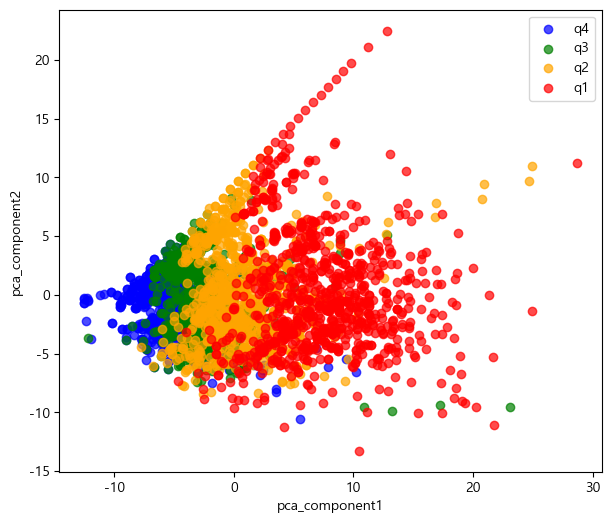

In [22]:
# 4등분 2D
# pca
fig = plt.figure(figsize=(7, 6))
ax2 = fig.add_subplot(111)

ax2.scatter(X_pca2D[q4, 0], X_pca2D[q4, 1], label='q4', c='blue', alpha=0.7)
ax2.scatter(X_pca2D[q3, 0], X_pca2D[q3, 1], label='q3', c='green', alpha=0.7)
ax2.scatter(X_pca2D[q2, 0], X_pca2D[q2, 1], label='q2', c='orange', alpha=0.7)
ax2.scatter(X_pca2D[q1, 0], X_pca2D[q1, 1], label='q1', c='red', alpha=0.7)

ax2.set_xlabel('pca_component1')
ax2.set_ylabel('pca_component2')
ax2.legend()

# # 저장
# file_name = f'pca_{dataset}.png'
# file_path = os.path.join(save_dir, file_name)
# print(file_path)
# plt.savefig(file_path, dpi = 300, bbox_inches = 'tight')

plt.show()

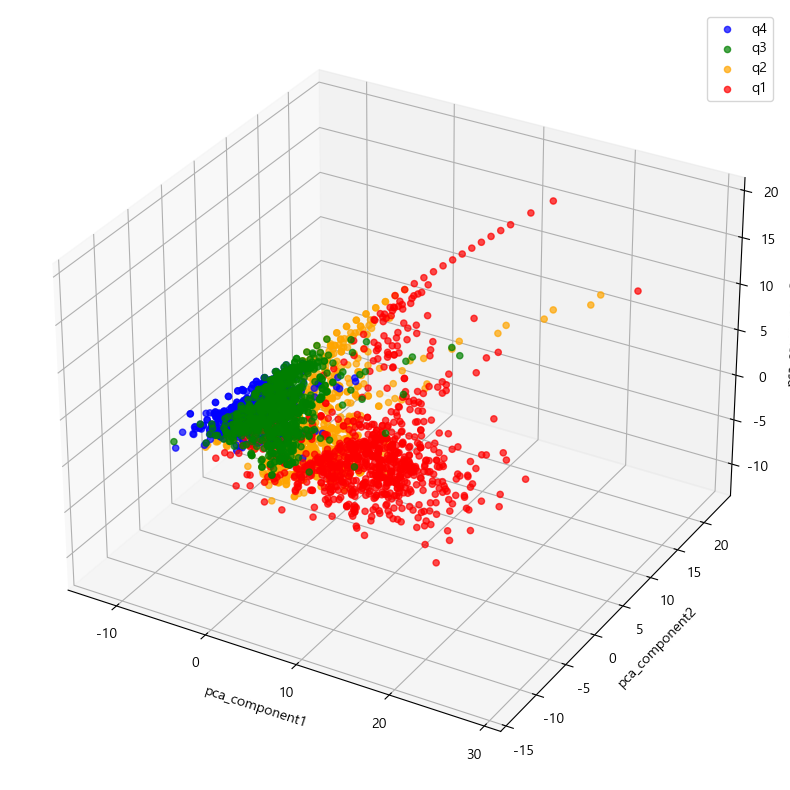

In [ ]:
# 4등분 3D
# pca
fig = plt.figure(figsize=(14, 10))
ax2 = fig.add_subplot(111, projection = '3d')

ax2.scatter(X_pca3D[q4, 0], X_pca3D[q4, 1], X_pca3D[q4, 2], label='q4', c='blue', alpha=0.7)
ax2.scatter(X_pca3D[q3, 0], X_pca3D[q3, 1], X_pca3D[q3, 2], label='q3', c='green', alpha=0.7)
ax2.scatter(X_pca3D[q2, 0], X_pca3D[q2, 1], X_pca3D[q2, 2], label='q2', c='orange', alpha=0.7)
ax2.scatter(X_pca3D[q1, 0], X_pca3D[q1, 1], X_pca3D[q1, 2], label='q1', c='red', alpha=0.7)

ax2.set_xlabel('pca_component1')
ax2.set_ylabel('pca_component2')
ax2.set_zlabel('pca_component3')
ax2.legend()

# # 저장
# file_name = f'pca_{dataset}.png'
# file_path = os.path.join(save_dir, file_name)
# print(file_path)
# plt.savefig(file_path, dpi = 300, bbox_inches = 'tight')

plt.show()

# t-SNE & PCA

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [26]:
X = np.array(df_removed_features.drop(columns = ['target']))
X.shape

(3562, 191)

In [35]:
perplexity = 5
method = 'barnes_hut' # default: barnes_hut, 'exact'
learning_rate = 'auto' # 'auto'
n_iter =1000

In [36]:
tsne = TSNE(n_components = 2, random_state = SEED, perplexity = perplexity, method = method, learning_rate = learning_rate, n_iter = n_iter)
tsne3D = TSNE(n_components = 3, random_state = SEED, perplexity = perplexity, method = method, learning_rate = learning_rate, n_iter = n_iter)

X_tsne = tsne.fit_transform(X)
X_tsne3D = tsne3D.fit_transform(X)

In [37]:
PCA_model2D = PCA(n_components = 2)
PCA_model3D = PCA(n_components = 3)

scaler = StandardScaler()

X_scaling = scaler.fit_transform(X)

X_pca2D = PCA_model2D.fit_transform(X_scaling)
X_pca3D = PCA_model3D.fit_transform(X_scaling)

In [38]:
target

0       2.750000
1       3.210000
2      -8.140000
3      -3.550000
4      -3.660000
          ...   
3557   -5.991400
3558   -6.657577
3559   -7.522879
3560   -7.045757
3561   -4.764472
Name: target, Length: 3562, dtype: float64

In [40]:

# target split
target = df_removed_features.iloc[:, -2]

# 1/3, 2/3 기준선
med1 = np.percentile(target, 33)
med2 = np.percentile(target, 66)

# 새로운 레이블 컬럼 생성
def label_target(x):
    if x < med1:
        return 'low'
    elif x < med2:
        return 'mid'
    else:
        return 'high'

df_removed_features['target_label'] = target.apply(label_target)

label_colors = {'low': 'red',
                'mid': 'blue',
                'high': 'green'}

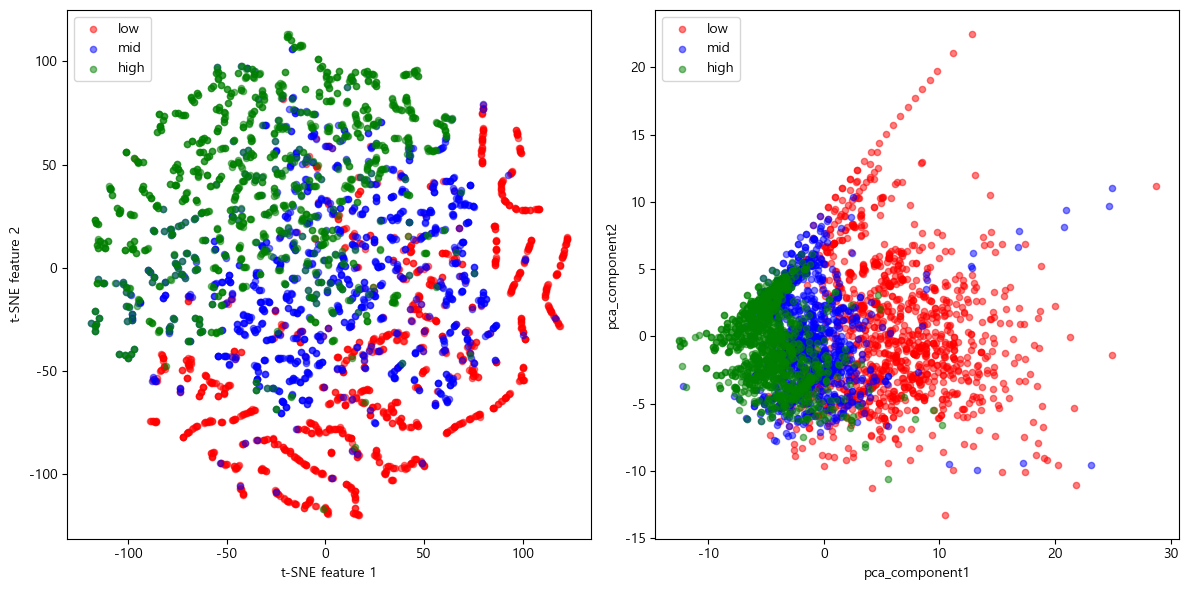

In [41]:
# t-SNE vs. PCA 2D
fig = plt.figure(figsize = (12, 6))

ax1 = plt.subplot(1, 2, 1)
for cls, color in label_colors.items():
    mask = df_removed_features['target_label'] == cls
    idxs = np.where(mask)[0]
    ax1.scatter(X_tsne[idxs, 0], X_tsne[idxs, 1],
                c = color, label = cls, s = 20, alpha = 0.5)

# ax1.set_title('t-SNE 2D Visualization by Class')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.legend(loc = 'upper left')

ax2 = plt.subplot(1, 2, 2)
for cls, color in label_colors.items():
    idxs = np.where(df_removed_features['target_label'] == cls)[0]
    ax2.scatter(X_pca2D[idxs, 0], X_pca2D[idxs, 1], 
                c = color, label = cls, s = 20, alpha = 0.5)

# ax2.set_title('PCA 2D Visualization by Class')
ax2.set_xlabel('pca_component1')
ax2.set_ylabel('pca_component2')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

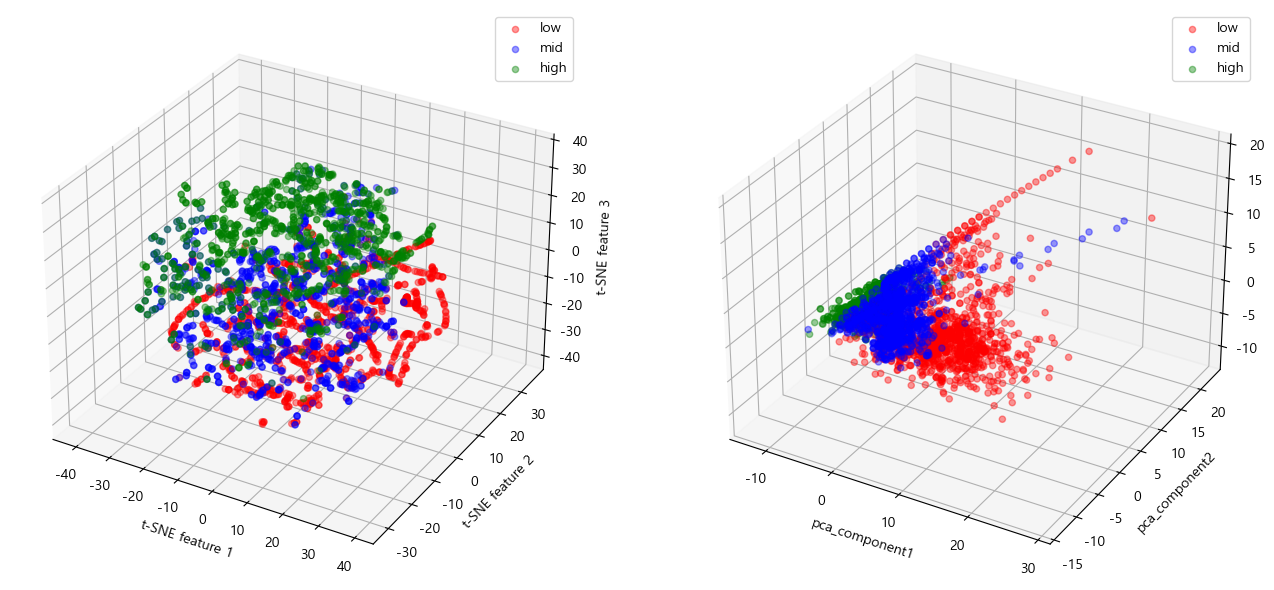

In [42]:
# t-SNE vs. PCA 3D
fig = plt.figure(figsize = (14, 6))

ax1 = fig.add_subplot(1,2,1, projection = '3d')
for cls, color in label_colors.items():
    mask = df_removed_features['target_label'] == cls
    idxs = np.where(mask)[0]
    ax1.scatter(X_tsne3D[idxs, 0], X_tsne3D[idxs, 1], X_tsne3D[idxs, 2],
                c = color, label = cls, s = 20, alpha = 0.4)

# ax1.set_title('t-SNE 3D Visualization by Class')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.set_zlabel('t-SNE feature 3')
ax1.legend(loc = 'best')

ax2 = fig.add_subplot(1,2,2, projection = '3d')
for cls, color in label_colors.items():
    idxs = np.where(df_removed_features['target_label'] == cls)[0]
    ax2.scatter(X_pca3D[idxs, 0], X_pca3D[idxs, 1], X_pca3D[idxs, 2],
                c = color, label = cls, s = 20, alpha = 0.4)

# ax2.set_title('PCA 3D Visualization by Class')
ax2.set_xlabel('pca_component1')
ax2.set_ylabel('pca_component2')
ax2.set_zlabel('pca_component3')
ax2.legend(loc = 'best')

plt.tight_layout()
plt.show()

In [43]:
# # 최종 사용할 것
# # PCA 3D 
# plt.figure(figsize = (14, 6))
# ax = plt.axes(projection='3d')

# for cls, color in label_colors.items():
#     idxs = np.where(df_removed_features['class']==cls)[0]
#     ax.scatter(X_pca3D[idxs, 0], X_pca3D[idxs, 1], X_pca3D[idxs, 2],
#                 c = color, label = cls, s = 80, alpha = 0.8, edgecolors='w')

# # ax2.set_title('PCA 3D Visualization by Class')
# ax.set_xlabel('pca_component1')
# ax.set_ylabel('pca_component2')
# ax.set_zlabel('pca_component3')
# ax.legend(
#     loc='right',
#     bbox_to_anchor=(1.07, 0.9)
# )

# plt.tight_layout()
# # fig.subplots_adjust(left=0.08, right=0.1, bottom=0.10, top=0.90)

# # # 저장
# # file_name = f'pca_{dataset}.png'
# # file_path = os.path.join(save_dir, file_name)
# # print(file_path)
# # plt.savefig(file_path, dpi = 300, bbox_inches = 'tight')

# plt.show()